# DeepTremor Time Series Forecasting

This notebook is a template for doing time series forecasting on the Ridgecrest dataset

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
# tf.enable_eager_execution()

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_random_seed(13)

/opt/anaconda3/envs/quakes/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/quakes/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/quakes/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/quakes/lib/python3.7/site-packages/tensorflow/pyth

## The Ridgecrest Dataset
This notebook uses a earthquake dataset from Ridgecrest, collected from July to September of 2019.
There are several thousand earthquakes during this time period, which were collected at anywhere from 16-30 stations.

In [2]:
dataset = np.load('../compressed_2/full_data.npy')
np.random.shuffle(dataset)

In [3]:
print("Before: ", dataset.shape)
#Swap axes
dataset = dataset.swapaxes(1, -1)

#Combine station and xyz
#dataset = dataset.reshape(dataset.shape[0], dataset.shape[1], -1)
print("After: ", dataset.shape)

Before:  (35679, 15, 60)
After:  (35679, 60, 15)


# Try normalizing

In [4]:
data_mean = np.mean(dataset, axis = 1)
data_var = np.linalg.norm(dataset - np.expand_dims(data_mean, 1), axis = 1)

#Add some epsilon to make the divide by zero var work
epsilon = 1
data_var[data_var == 0] = epsilon
data_var[data_var == 0] = epsilon

dataset = (dataset - np.expand_dims(data_mean, 1))/np.expand_dims(data_var, 1)

An observation is recorded every centisecond. This means that, for a single minute, you will have 60000 observations. 

Given a specific sequence, let's say you want to predict the future shaking of the earthquake at the next time point. In order to make this prediction, you choose to use 10 seconds of observations. Thus, you would create a window containing the last 1000 observations to train the model..

# Parsing in the dataset

In [5]:
def multivariate_data(dataset, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    
    start_index = history_size
    end_index = dataset.shape[1] - target_size
        
    for quake in dataset:

        for i in range(start_index, end_index):
            indices = range(i-history_size, i, step)
            data.append(quake[indices])

            if single_step:
                labels.append(quake[i+target_size])
            else:
                labels.append(quake[i:i+target_size])

    return np.array(data), np.array(labels)

In [6]:
past_history = 15
future_target = 1
STEP = 1
TRAIN_SPLIT_IDX = int(dataset.shape[0]*0.8)
x_train_single, y_train_single = multivariate_data(dataset[:TRAIN_SPLIT_IDX],past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset[TRAIN_SPLIT_IDX:], past_history,
                                               future_target, STEP,
                                               single_step=True)

In [7]:
x_train_single.shape, y_train_single.shape, x_val_single.shape, y_val_single.shape

((1255892, 15, 15), (1255892, 15), (313984, 15, 15), (313984, 15))

(array([8.74000000e+02, 2.10632000e+05, 1.31239720e+07, 1.95563409e+08,
        4.86419610e+07, 1.57806260e+07, 5.82736000e+06, 2.41061000e+06,
        8.90822000e+05, 1.25434000e+05]),
 array([-0.59701735, -0.43815829, -0.27929923, -0.12044017,  0.03841889,
         0.19727794,  0.356137  ,  0.51499606,  0.67385512,  0.83271418,
         0.99157323]),
 <a list of 10 Patch objects>)

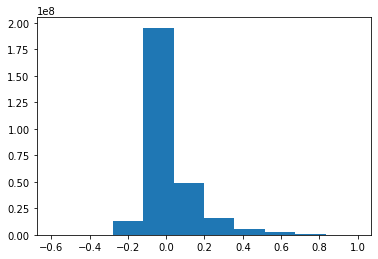

In [8]:
plt.hist(x_train_single.reshape(-1))

(array([8.0000000e+00, 3.5890000e+03, 3.3665100e+05, 1.2098017e+07,
        4.3201740e+06, 1.3376760e+06, 4.7325500e+05, 1.8884700e+05,
        6.9669000e+04, 1.0494000e+04]),
 array([-0.65262947, -0.48820336, -0.32377724, -0.15935113,  0.00507498,
         0.16950109,  0.3339272 ,  0.49835332,  0.66277943,  0.82720554,
         0.99163165]),
 <a list of 10 Patch objects>)

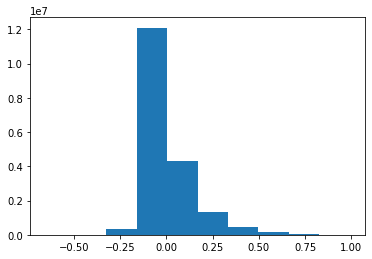

In [9]:
plt.hist(y_train_single.reshape(-1))

In [10]:
np.max(y_train_single, axis = 0)

array([0.99128032, 0.99160744, 0.99163165, 0.98548349, 0.99154403,
       0.99163165, 0.99110847, 0.9908039 , 0.99161067, 0.98510292,
       0.99163165, 0.9910839 , 0.99149158, 0.99154276, 0.9910514 ])

In [11]:
# Check the normalization
np.mean(x_train_single, axis = 1), np.linalg.norm(x_val_single, axis = 1), np.mean(x_val_single, axis = 1), np.linalg.norm(x_val_single, axis = 1)

(array([[-0.07130547, -0.05008104, -0.07056824, ..., -0.07178332,
         -0.05013665, -0.05956286],
        [-0.07258141, -0.05028443, -0.07067341, ..., -0.0734966 ,
         -0.04914007, -0.05861383],
        [-0.07386855, -0.05046575, -0.07025706, ..., -0.07367135,
         -0.04824702, -0.05911121],
        ...,
        [-0.03942962, -0.04152816, -0.04792494, ..., -0.02939843,
          0.05885181, -0.03932597],
        [-0.04031216, -0.04289901, -0.04764142, ..., -0.02958628,
          0.05954005, -0.04212031],
        [-0.042677  , -0.04303014, -0.04752671, ..., -0.02650594,
          0.03598101, -0.043731  ]]),
 array([[0.1818635 , 0.20423602, 0.13623176, ..., 0.39649099, 0.42233872,
         0.20743769],
        [0.18235776, 0.20698275, 0.13916427, ..., 0.36719645, 0.45292898,
         0.20877891],
        [0.1824677 , 0.20420306, 0.75726182, ..., 0.37574661, 0.44361308,
         0.20884699],
        ...,
        [0.22779077, 0.23047687, 0.27379324, ..., 0.21340798, 0.23319572

# Functions for visualizing data

In [12]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

In [13]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

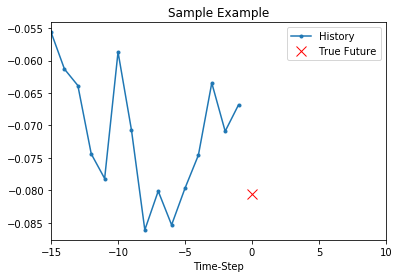

In [14]:
plot = show_plot([x_train_single[0, :, 0], y_train_single[0, 0]], 0, 'Sample Example')
plot.show()

### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [15]:
def baseline(history):
    return np.mean(history, axis = 0)

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/quakes/lib/python3.7/site-packages/matplotlib/pyplot.py'>

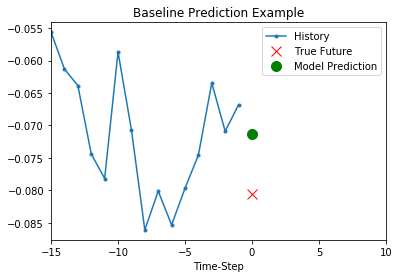

In [16]:
show_plot([x_train_single[0, :, 0], y_train_single[0, 0], baseline(x_train_single[0, :, 0])], 0,
           'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the [RNN tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent). In this tutorial, you will use a specialized RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM))


You will see the LSTM requires the input shape of the data it is being given.

As mentioned, the first step will be to normalize the dataset using the mean and standard deviation of the training data.

In [17]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(64,
                                          return_sequences=True,
                                          input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, activation='relu'))
single_step_model.add(tf.keras.layers.LSTM(32, activation='relu'))
single_step_model.add(tf.keras.layers.Dense(y_train_single.shape[-1]))

single_step_model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])
single_step_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 64)            20480     
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 32)            12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 15)                495       
Total params: 41,711
Trainable params: 41,711
Non-trainable params: 0
_________________________________________________________________


Let's check out a sample prediction.

In [18]:
print(single_step_model.predict(x_val_single[:2]))
print(single_step_model.predict(x_val_single[:2]).shape)

[[ 0.0043692   0.00330417  0.00407122  0.00423976 -0.00215591  0.00026629
   0.0029663  -0.00251506  0.00635108  0.00323794  0.00289679 -0.00148031
   0.00407622 -0.00166738  0.00028982]
 [ 0.00351746  0.00326248  0.00380925  0.0040166  -0.00259757  0.00050676
   0.00302491 -0.00268318  0.00535845  0.00193457  0.00271502 -0.00165338
   0.00366013 -0.00162193  0.00024775]]
(2, 15)


In [19]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,CSVLogger
from keras import optimizers

lr = 0.01

save_path = "./trained_models"
cur_file = "LSTM3"
cur_file = os.path.join(save_path, cur_file)

opt = optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
model_check = ModelCheckpoint(cur_file + '.h5', monitor='val_loss', verbose=1, save_best_only=True, 
                              save_weights_only=True, mode='min')
csv_log = CSVLogger(cur_file+ '_history.csv')
callback_list = [early_stop, reduce_lr, model_check, csv_log]


Using TensorFlow backend.


In [20]:
EPOCHS = 10
BATCH_SIZE = 4096
single_step_history = single_step_model.fit(x_train_single, y_train_single, epochs=EPOCHS,
                                            batch_size=BATCH_SIZE,
                                            validation_data=(x_val_single, y_val_single),
                                            callbacks=callback_list)

Train on 1255892 samples, validate on 313984 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1253376/1255892 [============================>.] - ETA: 0s - loss: 0.0680 - mean_absolute_error: 0.0680 - mean_squared_error: 0.0141
Epoch 00001: val_loss improved from inf to 0.06163, saving model to ./trained_models/LSTM3.h5
1255892/1255892 [==============================] - 50s 40us/sample - loss: 0.0679 - mean_absolute_error: 0.0679 - mean_squared_error: 0.0141 - val_loss: 0.0616 - val_mean_absolute_error: 0.0616 - val_mean_squared_error: 0.0119
Epoch 2/10
1253376/1255892 [============================>.] - ETA: 0s - loss: 0.0605 - mean_absolute_error: 0.0605 - mean_squared_error: 0.0115
Epoch 00002: val_loss improved from 0.06163 to 0.05954, saving model to ./trained_models/LSTM3.h5
1255892/1255892 [==============================] - 48s 38us/sample - loss: 0.0605 - mean_absolute_error: 0.0605 - mean_squared_error: 0.0115 - val_loss: 0.0595 - val_mean_absolute_error: 0.059

In [21]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

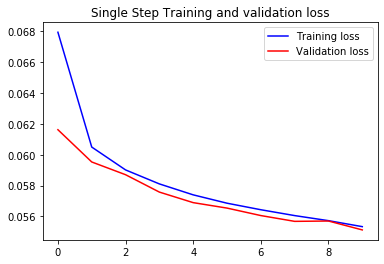

In [22]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction). 

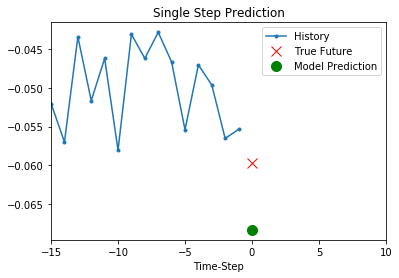

In [27]:
plot = show_plot([x_train_single[0, :, 1], y_train_single[0, 1],
                single_step_model.predict(x_train_single[0:2])[0, 0]], 0,
               'Single Step Prediction')
plot.show()

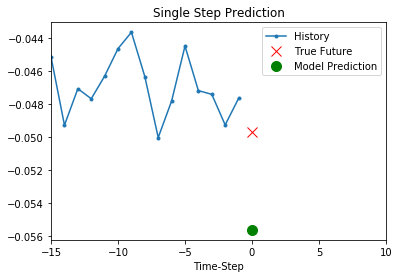

In [24]:
plot = show_plot([x_val_single[0, :, 0], y_val_single[0, 0],
                single_step_model.predict(x_val_single[0:2])[0, 0]], 0,
               'Single Step Prediction')
plot.show()

# Analyze the predictions of the model

In [25]:
y_pred = single_step_model.predict(x_val_single, batch_size = BATCH_SIZE).reshape(-1)
y_true = y_val_single.reshape(-1)
y_pred.shape, y_true.shape

((4709760,), (4709760,))

In [26]:
from sklearn import metrics

print("Explained Variance Score:", metrics.explained_variance_score(y_true, y_pred)) 
print("Max Error Score:", metrics.max_error(y_true, y_pred)) 
print("Mean Absolute Error Score:", metrics.mean_absolute_error(y_true, y_pred)) 
print("Mean Squared Error Score:", metrics.mean_squared_error(y_true, y_pred)) 
print("Median Absolute Error Score:", metrics.median_absolute_error(y_true, y_pred)) 
print("R2 Score:", metrics.r2_score(y_true, y_pred)) 

Explained Variance Score: 0.48242660786774294
Max Error Score: 1.0578138542490958
Mean Absolute Error Score: 0.0551297336638782
Mean Squared Error Score: 0.010081059252670086
Median Absolute Error Score: 0.023853712856316128
R2 Score: 0.46704057576054514


In [28]:
# A function to reconstruct the original data
num_samples_per_quake = (x_train_single.shape[0] + x_val_single.shape[0])//dataset.shape[0]
num_quakes_in_val = x_val_single.shape[0]//num_samples_per_quake

print("Num samples per quake", num_samples_per_quake)
print("Num quakes in val", num_quakes_in_val)

Num samples per quake 44
Num quakes in val 7136


In [29]:
def recover_quake(y_pred, data, means, norms):
    y_pred = y_pred.reshape((num_quakes_in_val, -1, 15))
    data = data[-num_quakes_in_val:, past_history+future_target:]
    
    data = data*np.expand_dims(norms, 1) + np.expand_dims(means, 1)
    y_pred = y_pred*np.expand_dims(norms, 1) + np.expand_dims(means, 1)

    return data, y_pred

In [30]:
real_y_true, real_y_pred = recover_quake(y_pred, dataset[-num_quakes_in_val:], data_mean[-num_quakes_in_val:], data_var[-num_quakes_in_val:])


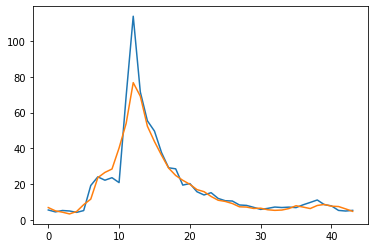

In [31]:
plt.figure()
plt.plot(real_y_true[-1, :, 0])
plt.plot(real_y_pred[-1, :, 0])
plt.show()

In [32]:
np.mean(np.abs(real_y_true-real_y_pred))

11.757969510722285

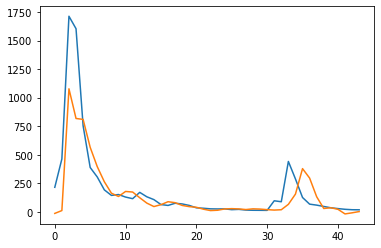

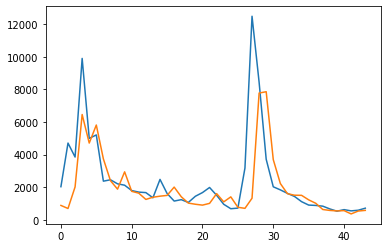

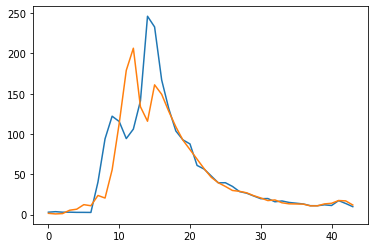

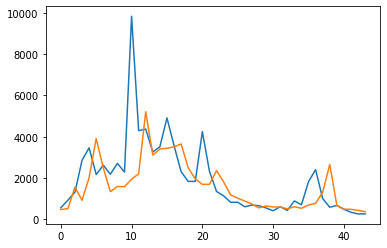

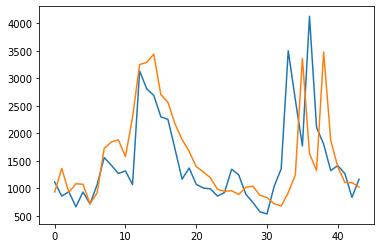

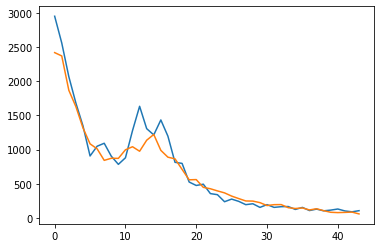

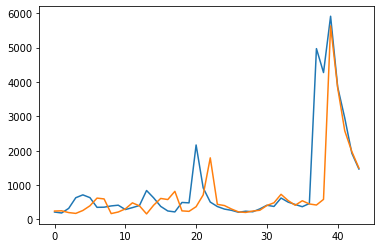

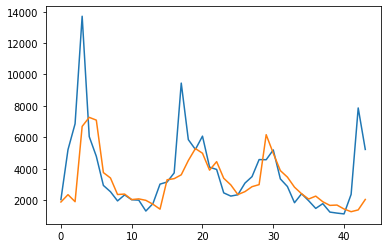

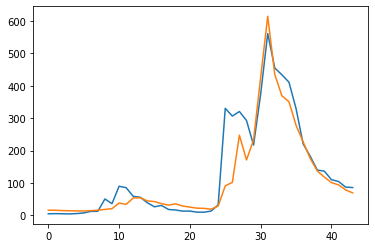

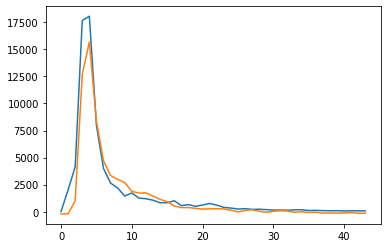

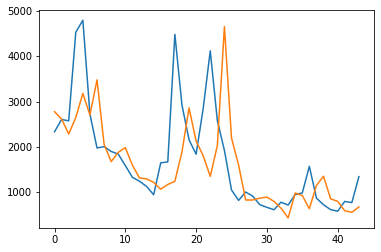

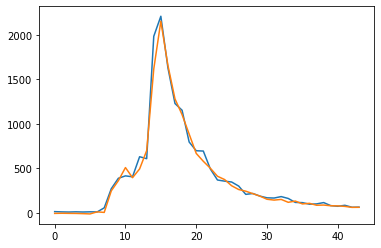

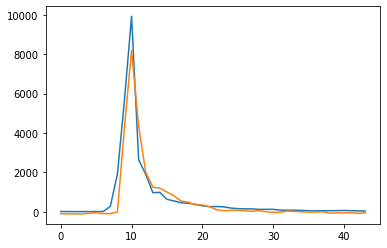

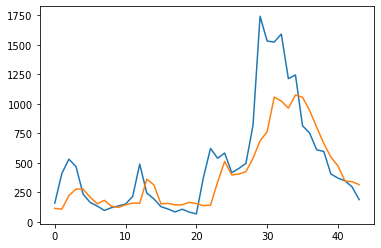

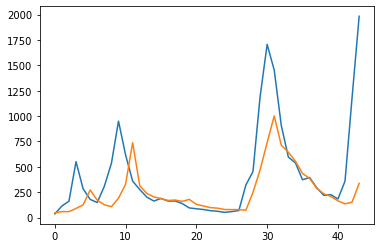

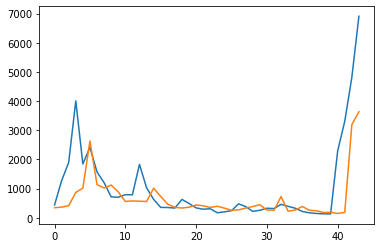

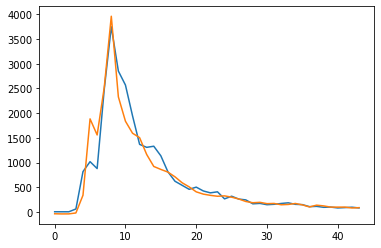

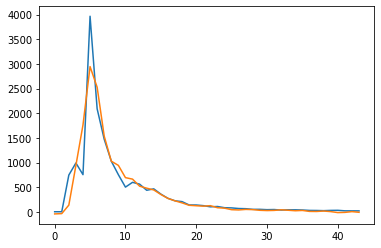

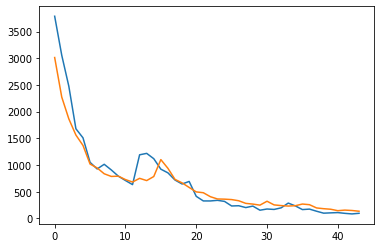

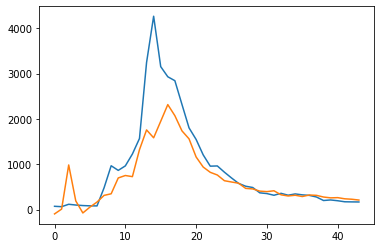

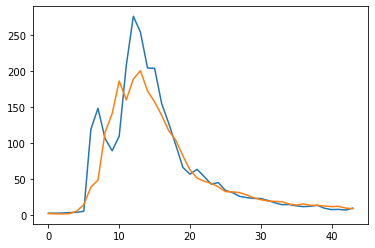

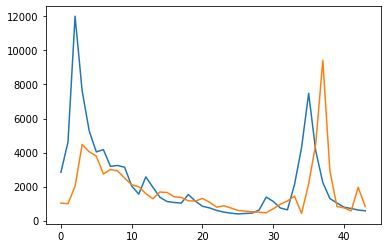

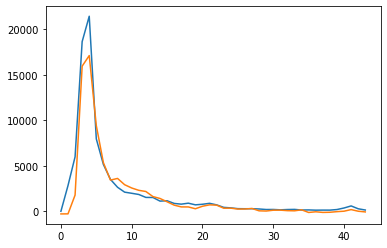

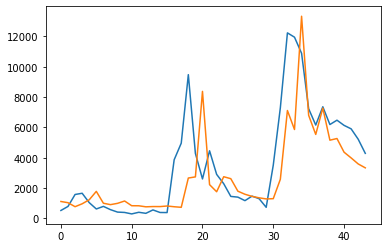

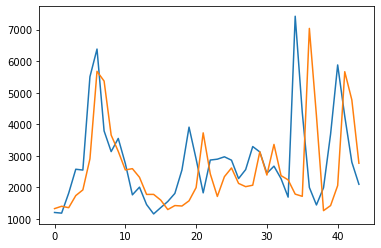

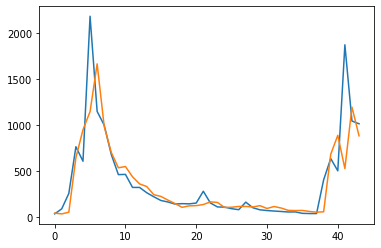

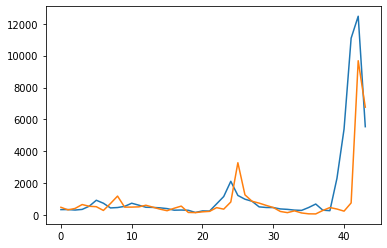

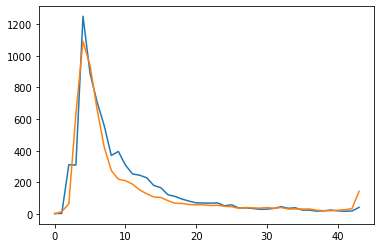

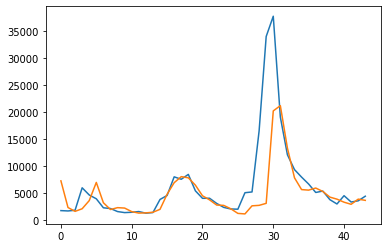

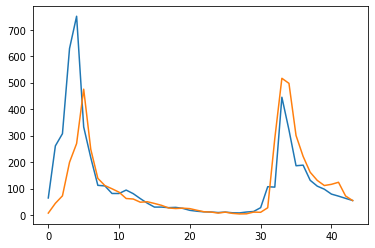

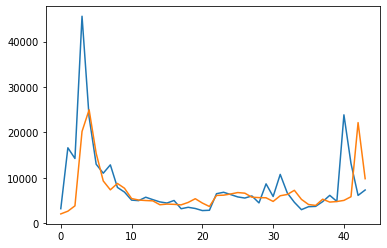

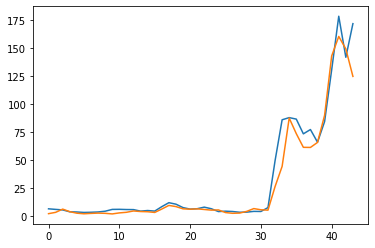

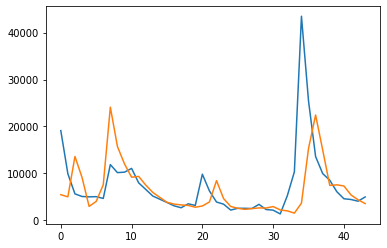

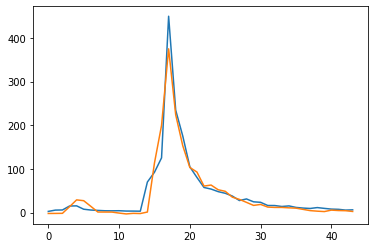

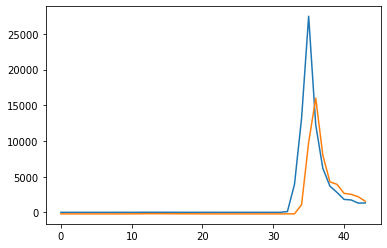

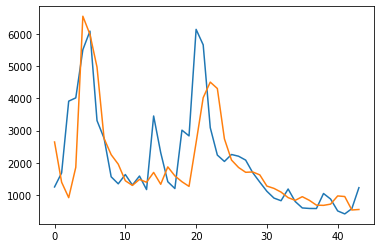

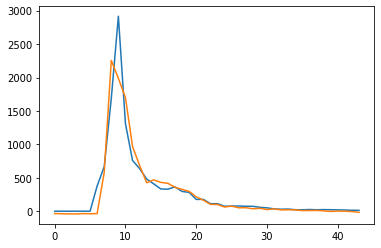

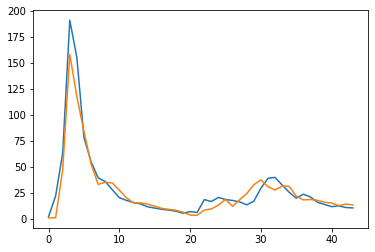

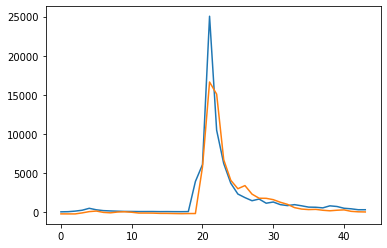

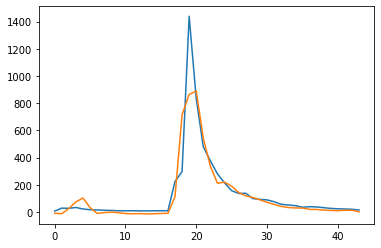

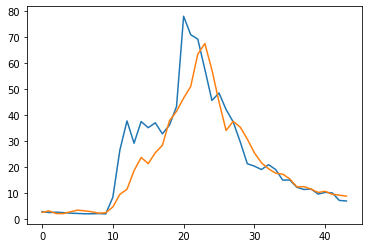

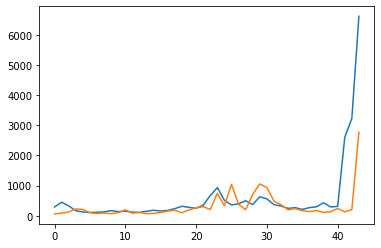

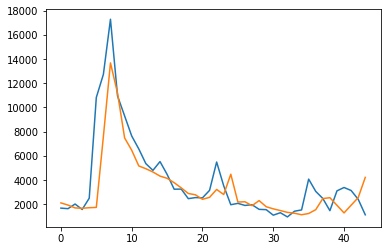

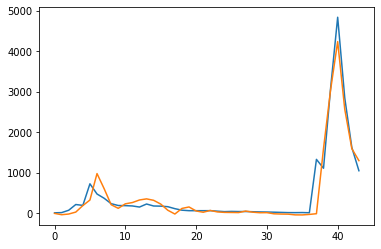

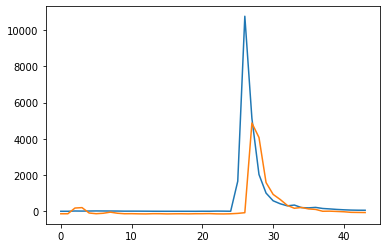

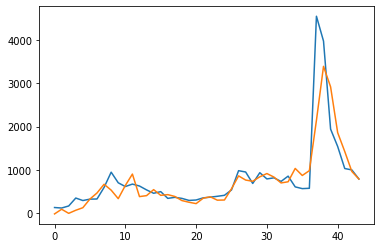

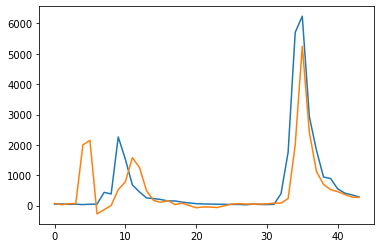

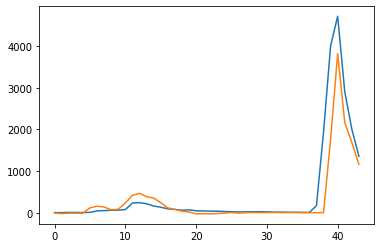

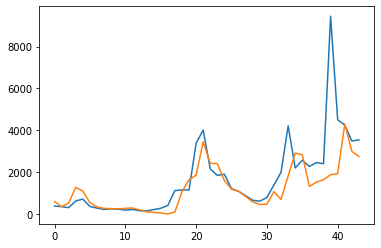

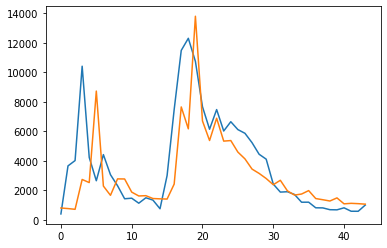

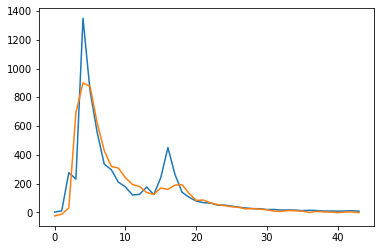

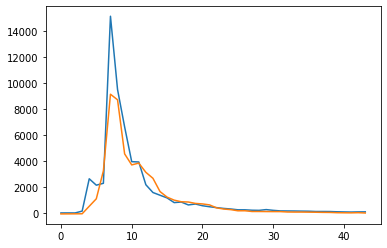

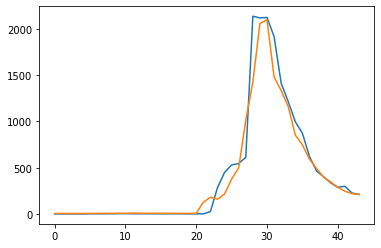

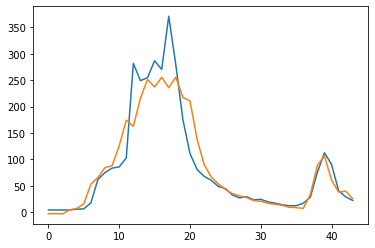

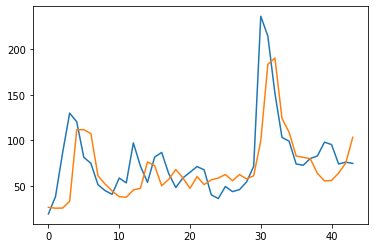

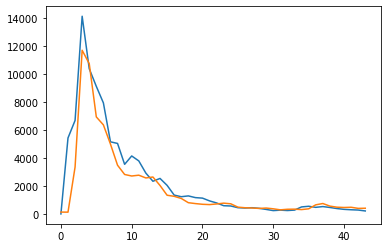

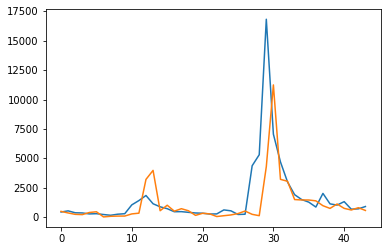

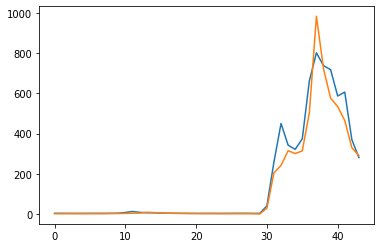

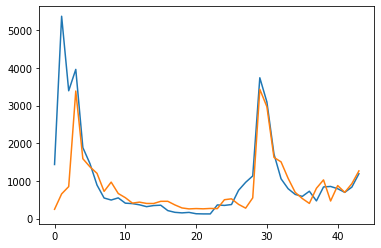

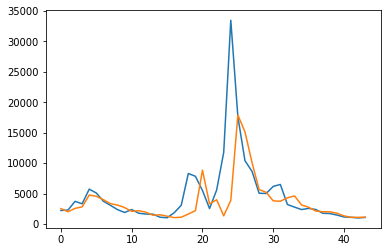

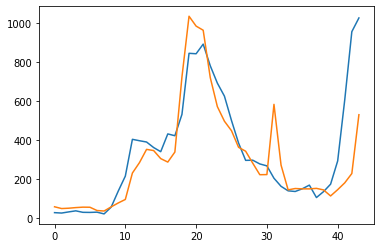

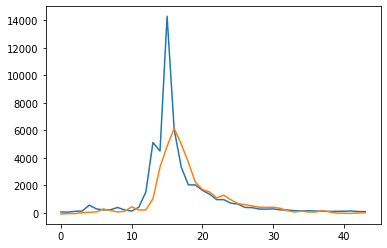

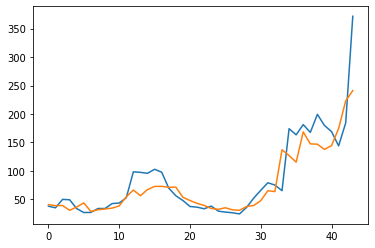

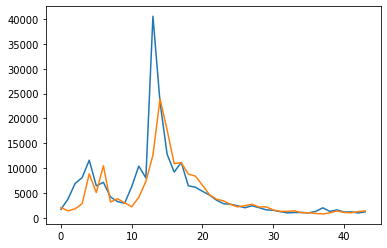

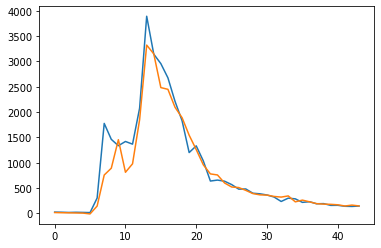

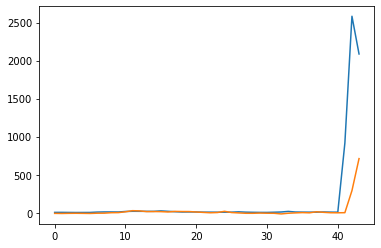

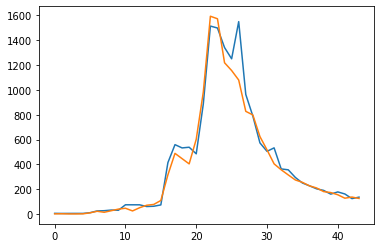

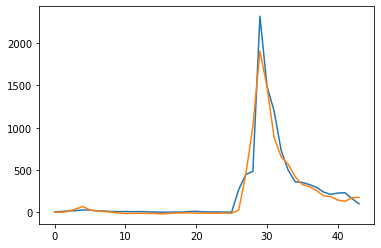

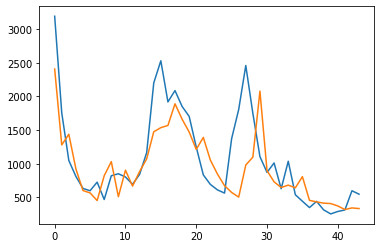

In [33]:
for idx in np.unique(np.argmax(real_y_true, axis = 0)):
    plt.figure()
    plt.plot(real_y_true[idx, :, 0])
    plt.plot(real_y_pred[idx, :, 0])
    plt.show()

### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [34]:
past_history = 15
future_target = 5
STEP = 1
TRAIN_SPLIT_IDX = int(dataset.shape[0]*0.8)

x_train_multi, y_train_multi = multivariate_data(dataset[:TRAIN_SPLIT_IDX], past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset[TRAIN_SPLIT_IDX:], past_history,
                                             future_target, STEP)

#Need to reshape y to be 2d
y_train_multi = y_train_multi.reshape(y_train_multi.shape[0], -1)
y_val_multi = y_val_multi.reshape(y_val_multi.shape[0], -1)

print(x_train_multi.shape, y_train_multi.shape, x_val_multi.shape, y_val_multi.shape)

(1141720, 15, 15) (1141720, 75) (285440, 15, 15) (285440, 75)


Let's check out a sample data-point.

In [35]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target earthquake signal to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (15, 15)

 Target earthquake signal to predict : (75,)


Plotting a sample data-point.

In [36]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future[:, 0]), 'b--',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction[:, 0]), 'r--',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

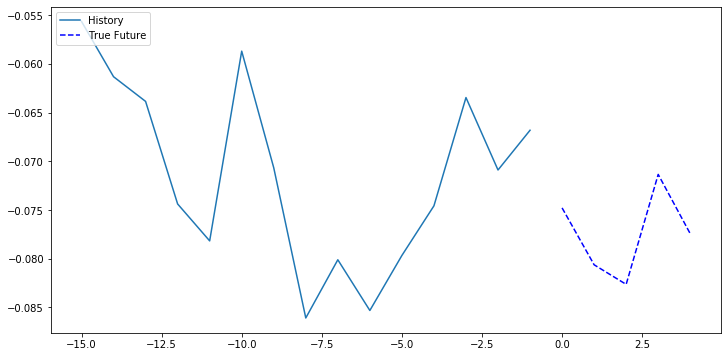

In [37]:
multi_step_plot(x_train_multi[0], y_train_multi[0].reshape(-1, 15), np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers.

In [38]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(64,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, activation='relu'))
multi_step_model.add(tf.keras.layers.LSTM(32, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(y_train_multi.shape[-1]))

multi_step_model.compile(optimizer='adam', loss='mae', metrics= ['mse', 'mae'])
multi_step_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 15, 64)            20480     
_________________________________________________________________
lstm_4 (LSTM)                (None, 15, 32)            12416     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 75)                2475      
Total params: 43,691
Trainable params: 43,691
Non-trainable params: 0
_________________________________________________________________


Let's see how the model predicts before it trains.

In [39]:
print(multi_step_model.predict(x_val_multi, batch_size = BATCH_SIZE).shape)

(285440, 75)


In [40]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,CSVLogger
from keras import optimizers

lr = 0.01

save_path = "./trained_models"
cur_file = "LSTM3_multi"
cur_file = os.path.join(save_path, cur_file)

opt = optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
model_check = ModelCheckpoint(cur_file + '.h5', monitor='val_loss', verbose=1, save_best_only=True, 
                              save_weights_only=True, mode='min')
csv_log = CSVLogger(cur_file+ '_history.csv')
callback_list = [early_stop, reduce_lr, model_check, csv_log]


In [41]:
EPOCHS = 10
multi_step_history = multi_step_model.fit(x_train_multi, y_train_multi, epochs=EPOCHS,
                                          validation_data=(x_val_multi, y_val_multi), 
                                          batch_size = BATCH_SIZE, callbacks=callback_list)

Train on 1141720 samples, validate on 285440 samples
Epoch 1/10
1138688/1141720 [============================>.] - ETA: 0s - loss: 0.0742 - mean_squared_error: 0.0164 - mean_absolute_error: 0.0742
Epoch 00001: val_loss improved from inf to 0.06841, saving model to ./trained_models/LSTM3_multi.h5
1141720/1141720 [==============================] - 47s 41us/sample - loss: 0.0742 - mean_squared_error: 0.0163 - mean_absolute_error: 0.0742 - val_loss: 0.0684 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0684
Epoch 2/10
1138688/1141720 [============================>.] - ETA: 0s - loss: 0.0670 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0670
Epoch 00002: val_loss improved from 0.06841 to 0.06588, saving model to ./trained_models/LSTM3_multi.h5
1141720/1141720 [==============================] - 45s 39us/sample - loss: 0.0670 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0670 - val_loss: 0.0659 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0659
E

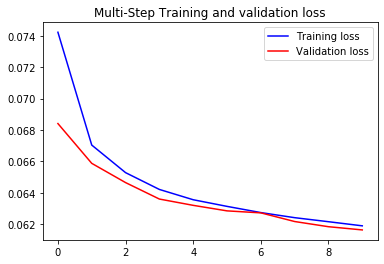

In [42]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

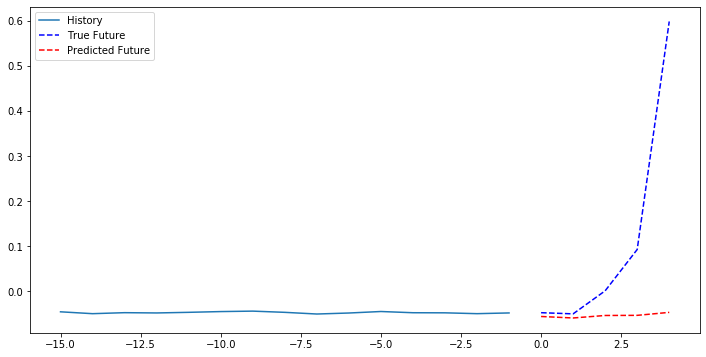

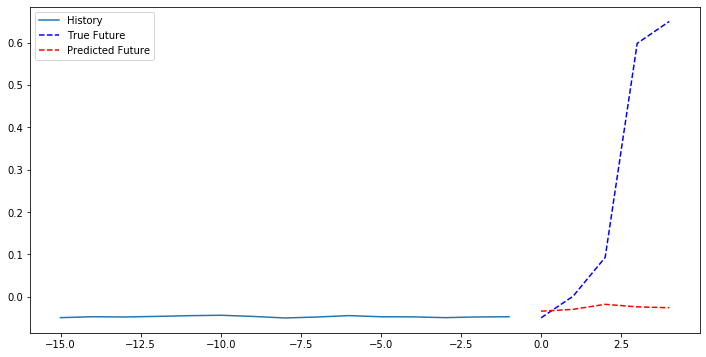

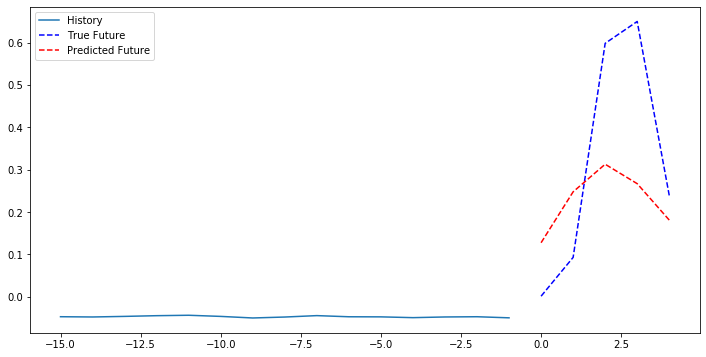

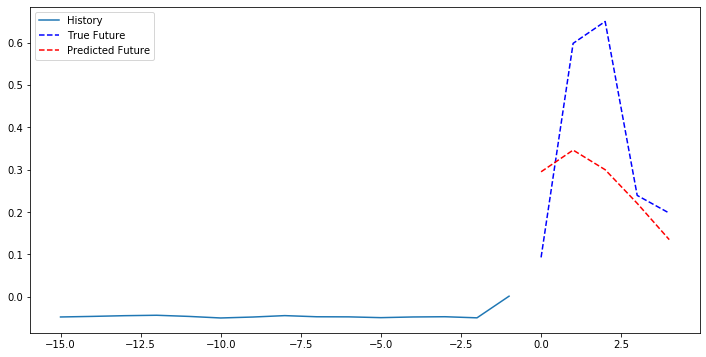

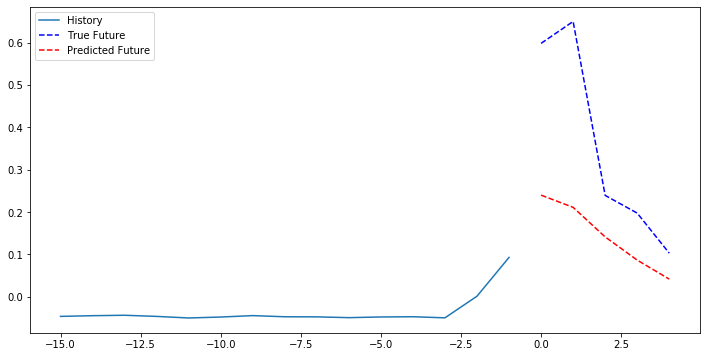

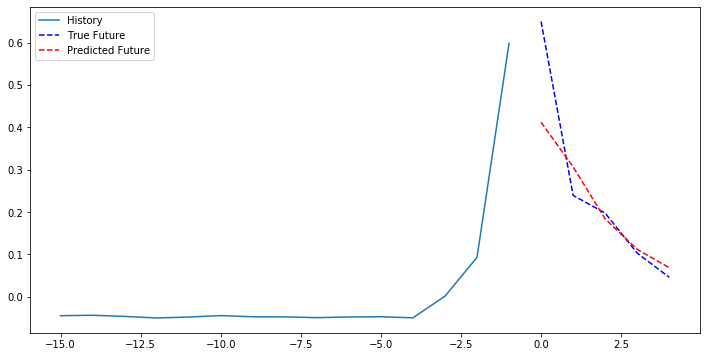

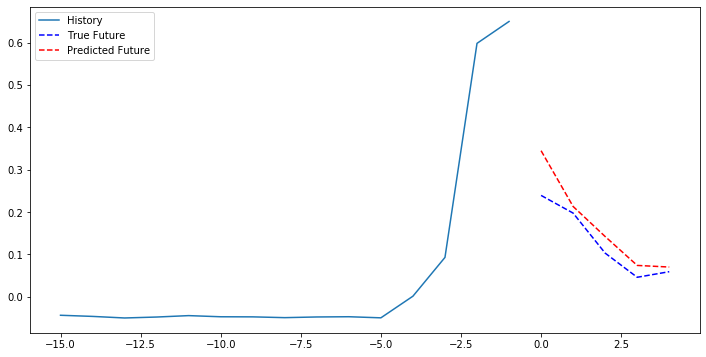

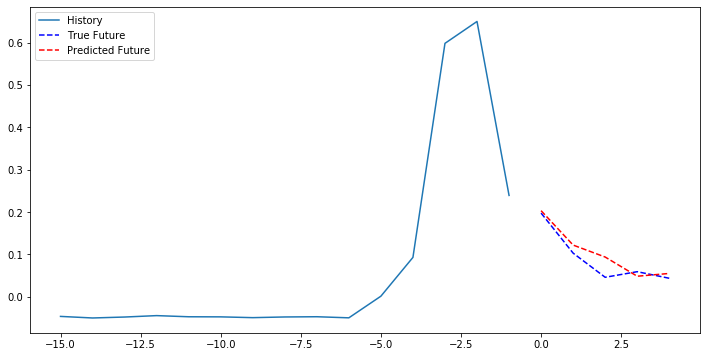

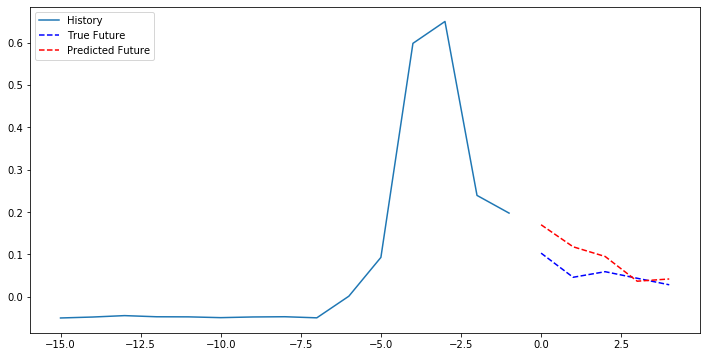

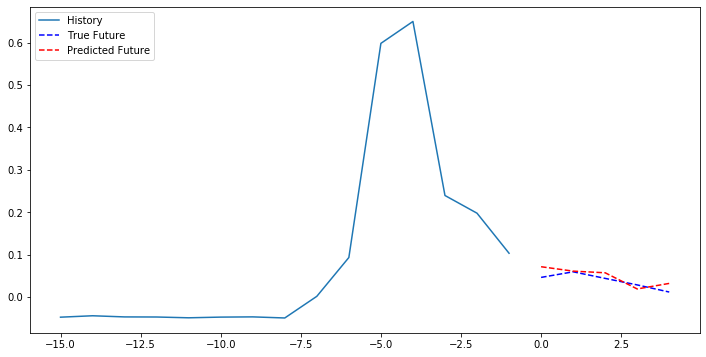

In [43]:
x = x_val_multi[:20]
y = y_val_multi[:20].reshape(len(x), -1, 15)
pred_y = multi_step_model.predict(x).reshape(len(x), -1, 15)
for i in range(10):
    multi_step_plot(x[i], y[i], pred_y[i])

In [44]:
pred_y = multi_step_model.predict(x_val_multi, batch_size = BATCH_SIZE).reshape(len(x_val_multi), -1, 15)
pred_y.shape

(285440, 5, 15)

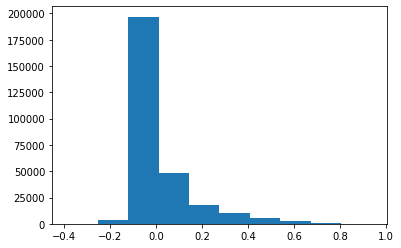

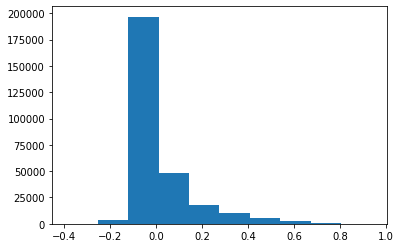

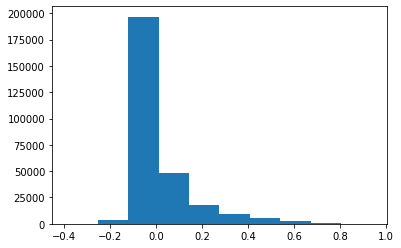

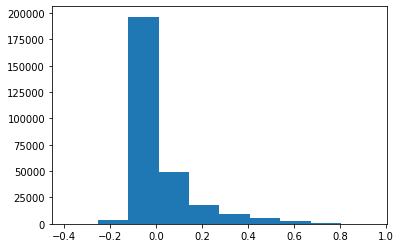

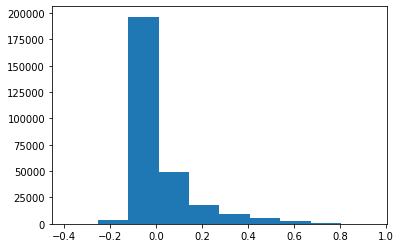

In [45]:
for i in range(5):
    plt.figure()
    data = x_val_multi[:, i, 0]
    data = data[data < 100]
    plt.hist(data)
    plt.show()

# Analyze the predictions of the model

In [46]:
y_pred = multi_step_model.predict(x_val_multi, batch_size = BATCH_SIZE).reshape(-1)
y_true = y_val_multi.reshape(-1)
y_pred.shape, y_true.shape

((21408000,), (21408000,))

In [47]:
from sklearn import metrics

print("Explained Variance Score:", metrics.explained_variance_score(y_true, y_pred)) 
print("Max Error Score:", metrics.max_error(y_true, y_pred)) 
print("Mean Absolute Error Score:", metrics.mean_absolute_error(y_true, y_pred)) 
print("Mean Squared Error Score:", metrics.mean_squared_error(y_true, y_pred)) 
print("Median Absolute Error Score:", metrics.median_absolute_error(y_true, y_pred)) 
print("R2 Score:", metrics.r2_score(y_true, y_pred)) 

Explained Variance Score: 0.3884302878027285
Max Error Score: 1.0509894850787487
Mean Absolute Error Score: 0.06163604361890034
Mean Squared Error Score: 0.012157558153073435
Median Absolute Error Score: 0.028120517662335615
R2 Score: 0.36707914481849424
